In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
%matplotlib inline

In [2]:
rawData = pd.read_csv('ED_COVID19_dashboard4_7_2020.csv')

In [3]:
rawData.COVID19_POSTIVE.value_counts(dropna=False)

NaN    1331
Y       472
Name: COVID19_POSTIVE, dtype: int64

In [4]:
# identify covid cases
#rawData.loc[(rawData.ED_LAB_COVID19=="Positive") | (rawData.ED_LAB_COVID19=="Presumptive Positive"), 'ED_LAB_COVID19']  ="Detected"   
#rawData.loc[(rawData.ED_LAB_COVID19=="Not Detected"), 'ED_LAB_COVID19'] ="Not detected"  
#rawData = rawData.loc[(rawData.ED_LAB_COVID19 == 'Detected') | (rawData.ED_LAB_COVID19 == 'Not detected')]
rawData['covid'] = rawData.COVID19_POSTIVE=="Y"
rawData = rawData.loc[rawData.covid]

In [5]:
# clean outcomes
rawData.loc[(rawData.ED_PM_EXPIRED_IN_ED_YN=="Y"), 'ED_ADMIT_TO_ICU_YN'] = 1
rawData['icu'] = rawData.ED_ADMIT_TO_ICU_YN=="Y"


In [6]:
rawData.COVID19_POSTIVE.value_counts()

Y    472
Name: COVID19_POSTIVE, dtype: int64

In [7]:
pd.crosstab(rawData.covid, rawData.icu, dropna=False )

icu,False,True
covid,,
True,413,59


In [8]:
# truncate high low lab values and convert to floats
rawData.ED_LAB_CRP.replace('<0.2', 0.1, inplace=True)

rawData.ED_LAB_DDIMER.replace('<0.17', 0.085, inplace=True)
rawData.ED_LAB_DDIMER.replace('>35.00', 40, inplace=True)

rawData.ED_LAB_FERRITIN.replace('>16500.0', 17000, inplace=True)
rawData.ED_LAB_FERRITIN.replace('>1650.0', 17000, inplace=True)

rawData.ED_LAB_IL6.replace('>3670.0', 4100, inplace=True)
rawData.ED_LAB_IL6.replace('>4060.0', 4100, inplace=True)
rawData.ED_LAB_IL6.replace('<4.0', 2, inplace=True)


rawData.ED_LAB_CMP_ALT.replace('<8', 4, inplace=True)

rawData.ED_LAB_HSTROP0.replace('<6', 3, inplace=True)
rawData.ED_LAB_HSTROP2.replace('<6', 3, inplace=True)

rawData.ED_LAB_CBC_PLT.replace('<2', 1, inplace=True)
rawData.ED_LAB_CMP_CR.replace('SEE BELOW', np.nan, inplace=True)
rawData.ED_LAB_CMP_CR.replace('<0.10', 0.005, inplace=True)

rawData.ED_LAB_CBC_HGB.replace('SEE BELOW', np.nan, inplace=True)
rawData.ED_LAB_VBG_LAC.replace('SEE BELOW', np.nan, inplace=True)

rawData.ED_LAB_CRP = rawData.ED_LAB_CRP.astype('float')
rawData.ED_LAB_DDIMER = rawData.ED_LAB_DDIMER.astype('float')
rawData.ED_LAB_FERRITIN = rawData.ED_LAB_FERRITIN.astype('float')
rawData.ED_LAB_IL6 = rawData.ED_LAB_IL6.astype('float')
rawData.ED_LAB_CMP_ALT = rawData.ED_LAB_CMP_ALT.astype('float')
rawData.ED_LAB_HSTROP0 = rawData.ED_LAB_HSTROP0.astype('float')
rawData.ED_LAB_HSTROP2 = rawData.ED_LAB_HSTROP2.astype('float')
rawData.ED_LAB_CBC_PLT = rawData.ED_LAB_CBC_PLT.astype('float')
rawData.ED_LAB_CMP_CR = rawData.ED_LAB_CMP_CR.astype('float')
rawData.ED_LAB_CBC_HGB =  rawData.ED_LAB_CBC_HGB.astype('float')
rawData.ED_LAB_VBG_LAC =  rawData.ED_LAB_VBG_LAC.astype('float')
rawData.ED_LAB_LDH =  rawData.ED_LAB_LDH.astype('float')
rawData.ED_LAB_CMP_ALB =  rawData.ED_LAB_CMP_ALB.astype('float')
rawData.TRIAGE_HR = rawData.TRIAGE_HR.astype('float')
rawData.TRIAGE_RR = rawData.TRIAGE_RR.astype('float')

rawData.ED_LAB_CMP_TBILI = rawData.ED_LAB_CMP_TBILI.astype('float')



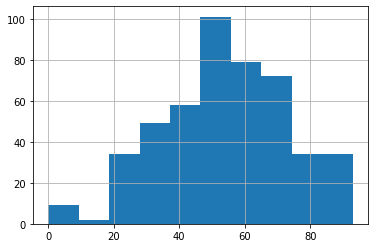

In [9]:
rawData.AGE_AT_VISIT_YRS.hist()

In [10]:
rawData.GENDER.value_counts()
rawData['female'] = rawData.GENDER=="F"
rawData.female = rawData.female.astype('int')

In [11]:
rawData['highFi02'] = rawData.TRIAGE_FIO2 > 50
rawData['highFi02'] = rawData['highFi02'].astype('int')

In [12]:
rawData = rawData[['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'TRIAGE_HR', 'TRIAGE_RR',
                   'TRIAGE_TEMP', 'highFi02', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 'ED_LAB_FERRITIN', 
                   'ED_LAB_CBC_PLT', 'ED_LAB_CBC_LYM', 'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 
                   'ED_LAB_HSTROP0', 'ED_LAB_IL6', 'covid', 'icu', 'ED_LAB_CBC_HGB', 'ED_LAB_VBG_LAC', 
                   'ED_LAB_LDH', 'ED_LAB_CMP_ALB']] 

In [13]:
rawData.female.value_counts()

0    244
1    228
Name: female, dtype: int64

In [14]:
# impute missing lab and vitals values

import statsmodels.imputation.mice as mice

def ols_formula(df, dependent_var):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    fml = ''
    for col in df_columns:
        fml = fml + ' + ' + col
    return fml

imputedData = mice.MICEData(rawData)

for var in ['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 
            'ED_LAB_FERRITIN', 'ED_LAB_CBC_PLT', 'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 'ED_LAB_HSTROP0', 
            'ED_LAB_IL6', 'ED_LAB_CBC_LYM', 'ED_LAB_CBC_HGB', 'ED_LAB_VBG_LAC', 'ED_LAB_LDH', 'ED_LAB_CMP_ALB',
            'TRIAGE_HR', 'TRIAGE_RR',  'TRIAGE_TEMP']:
    imputedData.set_imputer(var, formula=ols_formula(rawData, var))

imputedData.update_all(20)

In [15]:
cleanedData = imputedData.data

In [16]:
cleanedData.rename(columns={'AGE_AT_VISIT_YRS' : 'age', 'TRIAGE_SBP' : 'sbp', 'TRIAGE_DBP' : 'dbp',
                            'TRIAGE_HR' : 'hr', 'TRIAGE_TEMP' : 'temp', 'ED_LAB_CRP' : 'crp', 
                            'ED_LAB_DDIMER' : 'dDimer', 'ED_LAB_FERRITIN' : 'ferritin',
                            'ED_LAB_CBC_PLT' : 'platelets', 'ED_LAB_CMP_CR' : 'creatinine',  
                            'ED_LAB_CMP_TBILI' : 'tbili', 'ED_LAB_HSTROP0' : 'hsTrop', 
                            'ED_LAB_IL6' : 'il6', 'ED_LAB_CBC_LYM' : 'lymph',
                            'ED_LAB_CBC_HGB': 'hgb', 'ED_LAB_VBG_LAC':'lac', 'ED_LAB_LDH':'ldh',
                            'ED_LAB_CMP_ALB': 'albumin', 'TRIAGE_HR':'hr',
                           'TRIAGE_RR':'rr', 'TRIAGE_TEMP':'temp'}, inplace=True)

In [17]:
cleanedData

,age,female,sbp,dbp,hr,rr,temp,highFi02,crp,dDimer,...,creatinine,tbili,hsTrop,il6,covid,icu,hgb,lac,ldh,albumin
0,55.056,1,146.0,110.0,109.0,20.0,99.5,0,8.7,4.15,...,0.64,0.7,13.0,62.7,True,False,14.8,1.2,260.0,4.6
1,60.195,0,110.0,65.0,105.0,24.0,99.5,0,17.3,1.48,...,1.07,2.0,3.0,38.6,True,False,14.9,2.0,751.0,3.6
2,32.023,1,155.0,84.0,81.0,18.0,98.6,0,7.0,0.53,...,1.39,0.3,9.0,11.6,True,False,13.0,1.0,338.0,3.6
3,55.636,1,126.0,70.0,94.0,20.0,102.9,0,8.0,1.48,...,0.86,0.8,17.0,36.7,True,False,10.9,0.9,359.0,3.9
4,66.654,0,155.0,84.0,88.0,22.0,99.3,0,16.0,40.00,...,0.69,0.7,7.0,14.5,True,True,14.1,1.7,676.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,57.913,0,140.0,77.0,85.0,18.0,99.5,0,0.1,0.58,...,1.50,0.6,15.0,141.6,True,True,12.1,1.4,225.0,4.4
468,40.364,1,129.0,82.0,78.0,18.0,99.0,0,6.4,0.73,...,0.69,0.8,3.0,27.1,True,False,11.3,0.9,409.0,3.5
469,82.305,0,161.0,101.0,77.0,18.0,98.2,0,7.6,6.82,...,1.54,1.0,29.0,179.4,True,False,13.3,1.8,376.0,3.8
470,59.755,0,121.0,67.0,74.0,40.0,97.4,0,22.1,1.51,...,11.45,0.3,229.0,39.1,True,False,12.5,2.0,281.0,4.5


In [18]:
# crude sofa score on imputed dataset
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence

# pao2/fi02
cleanedData['sofa'] = 0 # for the PaO2/fio2 ratio — looks like almost all our peopel are on room air, and we don't have pa02 on many 
cleanedData.loc[cleanedData.highFi02, 'sofa'] = 2 # crudely give elevated points for high Fi01, 

# platelets
sofaPlateletPoints = {0 : 4, 1 : 3, 2: 2, 3: 1, 4: 0}
cleanedData['plateletCat'] = pd.cut(cleanedData.platelets, [0, 20, 49, 99, 149, 10000]).values.codes
cleanedData['plateletPoints'] = [sofaPlateletPoints[cat] for cat in cleanedData.plateletCat]
cleanedData['sofa'] = cleanedData.sofa + cleanedData.plateletPoints

#gcs - missing...will just impute 0.2 points for eerybody...most are going to be very low
cleanedData['sofa'] = cleanedData.sofa + 0.2 

# t bili
cleanedData['biliCat'] = pd.cut(cleanedData.tbili, [0, 1.2, 1.99, 5.99, 11.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.biliCat

# blood pressure — no pressor data for now...
cleanedData['map'] = cleanedData.sbp * 1/3 + cleanedData.dbp * 2/3
cleanedData.loc[cleanedData.map < 70, 'sofa'] = cleanedData.sofa + 1

# creatinine
cleanedData['creatCat'] = pd.cut(cleanedData.creatinine, [0, 1.19, 1.99, 3.49, 4.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.creatCat


In [19]:
modelData = cleanedData[['age', 'female', 'crp','dDimer', 'ferritin', 'hsTrop','icu', 'sofa', 
                         'lymph', 'hgb', 'lac', 'ldh', 'albumin', 'hr', 'rr', 'temp']]

In [20]:
modelData.head()

,age,female,crp,dDimer,ferritin,hsTrop,icu,sofa,lymph,hgb,lac,ldh,albumin,hr,rr,temp
0,55.056,1,8.7,4.15,532.9,13.0,False,2.2,35.7,14.8,1.2,260.0,4.6,109.0,20.0,99.5
1,60.195,0,17.3,1.48,3898.2,3.0,False,4.2,12.2,14.9,2.0,751.0,3.6,105.0,24.0,99.5
2,32.023,1,7.0,0.53,169.3,9.0,False,1.2,26.2,13.0,1.0,338.0,3.6,81.0,18.0,98.6
3,55.636,1,8.0,1.48,1687.3,17.0,False,0.2,17.5,10.9,0.9,359.0,3.9,94.0,20.0,102.9
4,66.654,0,16.0,40.00,1566.8,7.0,True,0.2,11.7,14.1,1.7,676.0,4.0,88.0,22.0,99.3


In [21]:
# crude priors from:  Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study. The Lancet, 1–9. http://doi.org/10.1016/S0140-6736(20)30566-3
import pymc3 as pm

# mean center all the variables...
#for var in ['crp', 'dDimer', 'ferritin', 'hsTrop', 'sofa','lymph', 'hbg', 'lac', 'ldh', 'albumin']:
#     modelData[var] = modelData[var] - modelData[var].mean()


In [38]:
def getBetaNameForLab(lab):
    return 'beta' + lab.capitalize()

labs = ['crp', 'dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac', 'ldh', 'albumin', 'hr', 'rr', 'temp']

with pm.Model() as logitICUWIthPriors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
    betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
    betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
    betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


    
    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for lab in labs:
        name = getBetaNameForLab(lab)
        setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(logitICUWIthPriors, lab, pm.Data(lab, modelData[lab]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + betaFemale * modelData.female
    for lab  in labs:   
        mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)
        
    θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.icu)

    trace_ICU = pm.sample(1000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaTemp, betaRr, betaHr, betaAlbumin, betaLdh, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaCrp, betaFemale, betaLymph, betaSofa, betaAge, alpha]
Sampling 4 chains, 4 divergences: 100%|██████████| 12000/12000 [01:24<00:00, 141.23draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.702118978089666, but should be close to 0.8. Try to increase the number of tuning steps.


In [39]:
ppc = pm.sample_ppc(trace_ICU, model=logitICUWIthPriors, samples=500)
modelData['posteriorProbabilities'] = ppc['y_1'].mean(axis=0)

preds = np.rint(modelData['posteriorProbabilities']).astype('int')
print(f'Accuracy: {accuracy_score(modelData.icu, preds):.3f}')
print(f'f1 score: {f1_score(modelData.icu, preds):.3f}')
roc = roc_auc_score(modelData.icu, modelData.posteriorProbabilities)
print(f'ROC: {roc:.3f}')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 669.98it/s]

Accuracy: 0.898
f1 score: 0.467
ROC: 0.864



/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
labsToKeep = []
marginalOutputsForLab = {}
marginalInputsForLab = {}
ninetyMinusTenForLab = {}


for var in labs:
    with logitICUWIthPriors:
        valuesToCheck = {'min': modelData[var].min(), '1st':modelData[var].quantile(0.01),
                         '10th':modelData[var].quantile(0.10), '25th':modelData[var].quantile(0.25), 
                         '50th':modelData[var].quantile(0.50), '75th':modelData[var].quantile(0.75), 
                         '90th':modelData[var].quantile(0.90), '99th':modelData[var].quantile(0.99),
                         'max':modelData[var].max()}
        ppcsAtValue = dict.fromkeys(valuesToCheck.keys())

        for key, value in valuesToCheck.items():
            pm.model.set_data({var: np.repeat(value, len(modelData))})
            pccsForLabValue = pm.sample_posterior_predictive(trace_ICU, samples=1000)
            ppcsAtValue[key] = pccsForLabValue['y_1'].mean(axis=0).mean()
            marginalOutputsForLab[var] = ppcsAtValue
            marginalInputsForLab[var] = valuesToCheck
        ninetyMinusTen = ppcsAtValue['90th'] - ppcsAtValue['10th']
        ninetyMinusTenForLab[var] = ninetyMinusTen

        if np.abs(ninetyMinusTen) > 0.05:
            labsToKeep.append(var)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 777.66it/s]


In [41]:
labsToKeep

['crp', 'ldh', 'rr']

In [42]:
ninetyMinusTenForLab

{'crp': 0.050088983050847455,
 'dDimer': 0.009165254237288117,
 'ferritin': -0.023152542372881335,
 'hsTrop': -0.010218220338983036,
 'hgb': -0.0026016949152542213,
 'lac': 0.001266949152542357,
 'ldh': 0.19313771186440676,
 'albumin': -0.000974576271186467,
 'hr': -0.016027542372881176,
 'rr': 0.08009957627118636,
 'temp': -0.0010338983050847128}

In [43]:
with logitICUWIthPriors:

    data = az.from_pymc3(
        trace=trace_ICU,
        prior=pm.sample_prior_predictive(),
        posterior_predictive=ppc,
        model=logitICUWIthPriors
    )


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [52]:
az.summary(trace_ICU, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                      'betaFemale', 'betaSofa', 'betaHr', 'betaRr', 'betaTemp','alpha' ])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betaCrp,0.042,0.020,0.004,0.080,0.000,0.000,4498.0,4064.0,4506.0,3202.0,1.0
betaFerritin,-0.000,0.000,-0.000,0.000,0.000,0.000,3638.0,2520.0,3673.0,2871.0,1.0
betaDdimer,0.023,0.025,-0.023,0.069,0.000,0.000,4711.0,2574.0,4711.0,2364.0,1.0
betaAge,0.026,0.012,0.006,0.048,0.000,0.000,3438.0,3329.0,3457.0,2576.0,1.0
betaHstrop,-0.002,0.006,-0.013,0.008,0.000,0.000,3774.0,2353.0,3811.0,2872.0,1.0
betaLymph,-0.027,0.021,-0.065,0.011,0.000,0.000,4276.0,3177.0,4320.0,3018.0,1.0
betaHgb,-0.008,0.045,-0.089,0.076,0.001,0.001,4850.0,1898.0,4939.0,2961.0,1.0
betaLac,0.020,0.048,-0.064,0.114,0.001,0.001,4110.0,2019.0,4090.0,2617.0,1.0
betaLdh,0.005,0.001,0.003,0.007,0.000,0.000,3338.0,3338.0,3326.0,2794.0,1.0
betaAlbumin,-0.008,0.050,-0.103,0.082,0.001,0.001,5499.0,1608.0,5507.0,2717.0,1.0


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3144f410>,
      dtype=object)

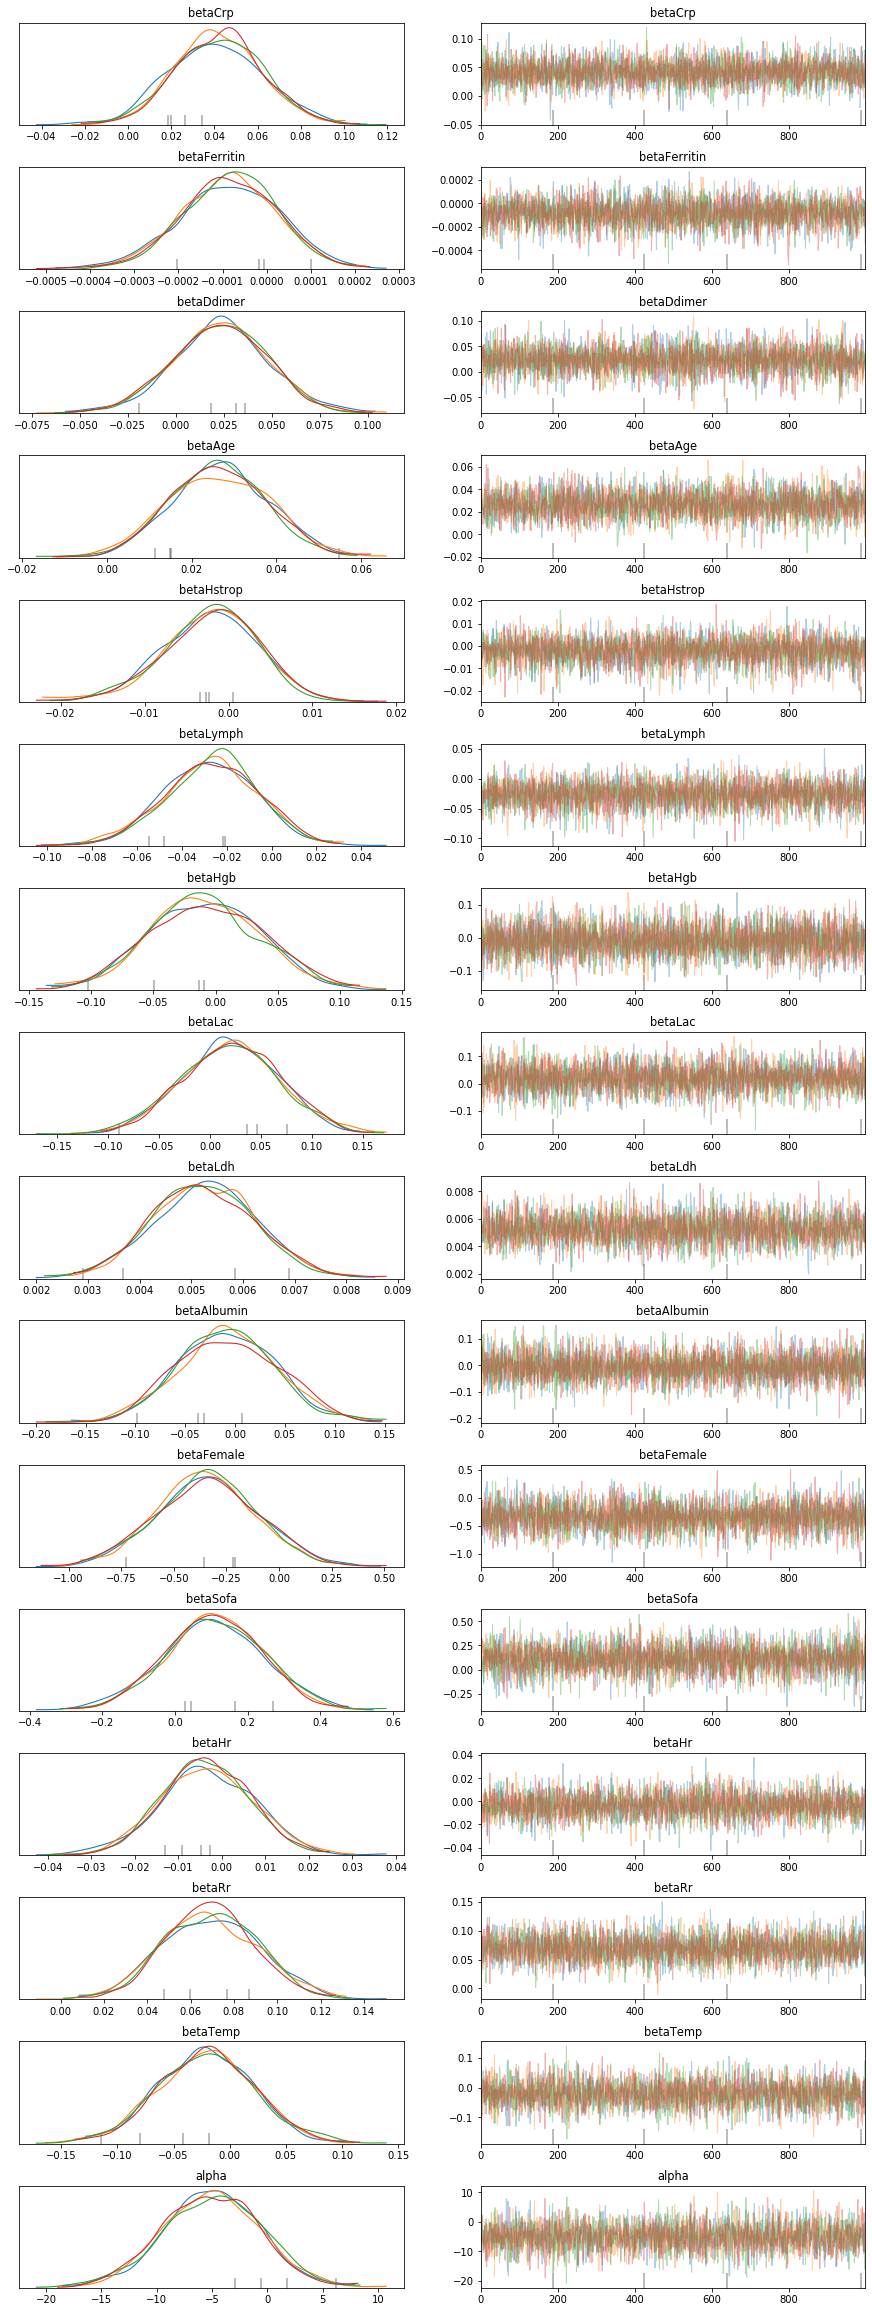

In [53]:
az.plot_trace(trace_ICU, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                    'betaFemale', 'betaSofa', 'betaHr', 'betaRr', 'betaTemp', 'alpha'])

In [54]:
outputDF = pd.DataFrame({'predictedProb' : modelData.posteriorProbabilities, 'icu' : modelData.icu})
outputDF['icuDecile'] = pd.qcut(outputDF.predictedProb, 10)

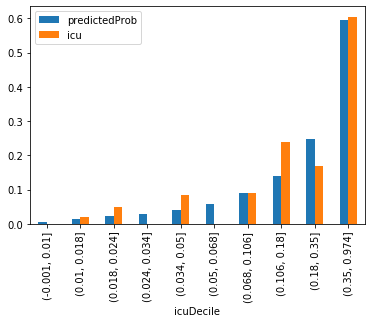

In [55]:
from datetime import date


# calibration looks perfectly decent.
outputDF.groupby('icuDecile').mean().plot.bar()
plt.savefig(f'calibration{str(date.today())}.jpg')

In [59]:
modelCoefficients = az.summary(trace_ICU, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                      'betaFemale', 'betaSofa',  'betaHr', 'betaRr', 'betaTemp', 'alpha'])[['mean', 'sd']]
modelCoefficients.rename(columns={'mean': 'beta', 'sd':'sdBeta'}, inplace=True)
for key, value in ninetyMinusTenForLab.items():
    modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'priority'] = np.abs(value)
    modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'p50'] = modelData[key].quantile(0.50)
    
for i, row in modelCoefficients.iterrows():
    if row.name[0:4] == 'beta':
        modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name[4:].lower()
    else:
        modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name

In [60]:
modelCoefficients

,beta,sdBeta,priority,p50,name
betaCrp,0.042,0.020,0.050089,6.95,crp
betaFerritin,-0.000,0.000,0.023153,683.90,ferritin
betaDdimer,0.023,0.025,0.009165,0.89,ddimer
betaAge,0.026,0.012,NaN,NaN,age
betaHstrop,-0.002,0.006,0.010218,13.00,hstrop
betaLymph,-0.027,0.021,NaN,NaN,lymph
betaHgb,-0.008,0.045,0.002602,13.30,hgb
betaLac,0.020,0.048,0.001267,1.30,lac
betaLdh,0.005,0.001,0.193138,360.00,ldh
betaAlbumin,-0.008,0.050,0.000975,4.10,albumin


In [61]:
import json

modelCoefficients.to_stata(f'icuAdmitCoeffs-{str(date.today())}.dta')
modelData.to_stata(f'modelData-{str(date.today())}.dta')


modelPerformance = {}
modelPerformance['roc'] = roc
modelPerformance['labsToKeep']=labsToKeep

with open(f'icuModelPerformance-{str(date.today())}.json', 'w') as outfile:
    json.dump(modelPerformance, outfile)

In [65]:
modelCoefficients.loc[modelCoefficients.name=='rr']['p50'].values[0]

20.0

In [35]:
# workflow...

# download data
# clean datat (in this worksheet)
# impute missing values
# run baseline model
# prioritize coefficients
# export coefficients, data file and model performance
# update the priority in teh UI — done
# 

In [36]:
# there is a fairly reasonable agreement between our baseline bayesian model and a default-tuned elastic net
# that seesm liek a decent argument that our pessimism was calibrated reasonably...

In [37]:
from glmnet import LogitNet

m = LogitNet()
m = m.fit(modelData.loc[:,!modelData.columns.in(['icu', 'posteriorProbabilities']), modelData.icu)

SyntaxError: invalid syntax (<ipython-input-37-3e104641e805>, line 4)

In [ ]:
modelData

In [ ]:
m.coef_